# Adversarial examples
In this notebook we are going to explore image classification in pytorch with a pretrained network. We will manufacture adversarial examples in order to fool the network into making wrong predictions. **You** will need to fill in the missing pieces to make things work. They are marked with `# TODO` and require a “wrong“ line of code to be replaced.

In [2]:
%matplotlib inline

import math

import matplotlib.pyplot as plt

import numpy as np

import skimage.data
import skimage.filters
import skimage.io

import torch
import torchvision

try:
    import seaborn as sns
    sns.set()
except:
    pass

At first, we load a convolutional neural network that classifies images. We do not want to build and/or train our own network. Instead, we load a predefined network from the `torchvision` module that is part of pytorch and set it up with pretrained weights. This network has been trained on 224 by 224 RGB images from ImageNet.

Using a pretrained network saves us a lot of work -- we do, however, need to respect how it expects inputs to be preprocessed. We wil take care of this in a bit.

In [3]:
# Load model.
model = torchvision.models.alexnet(pretrained=True)

# Set to evaluation mode.
model.eval()

# Define expected input size.
input_shape = (224, 224)

You can basically use any input image you want -- if you cannot download one from the internet at the moment, fall back to `image = skimage.data.chelsea()`.

If you try a number of images, you will see how the network handles different types of input. How does it, for example, handle an image with two distinct objects in it?

As mentioned above, the image needs to be of shape `(224, 224)`, so we crop and resize it accordingly.

In [4]:
# Load input image.
url = 'https://upload.wikimedia.org/wikipedia/commons/a/a8/Truck_carrying_a_large_load_in_Indore_%28front_view%29.JPG'
image = skimage.io.imread(url)

In [5]:
def center_crop(array):
    width, height = array.shape[0], array.shape[1]
    if width == height:
        return array
    if width < height:
        diff = height - width
        start = math.floor(diff / 2)
        end = math.ceil(diff / 2)
        return array[:, start:-end]
    if width > height:
        diff = width - height
        start = math.floor(diff / 2)
        end = math.ceil(diff / 2)
        return array[start:-end, :]

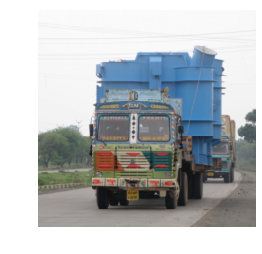

In [6]:
# Crop and resize image.
image = skimage.transform.resize(center_crop(image), input_shape, mode='reflect', anti_aliasing=True)

# Show image.
plt.imshow(image); plt.axis('off'); plt.grid(False)

Now comes the actual preprocessing. Right now, our image is a *numpy array* of shape `(width, height, n_channels)`, that is `(224, 224, 3)`, but we have to convert it into a *pytorch tensor*. The two are conceptually the same, which makes the conversion fairly straightforward. However, the network (as most networks in pytorch) is set up in way that it can handle multiple inputs at once, in so-called *batches*. Even though we only want to pass a single image through the network, the extra dimension must be respected. Also, the order for each image is different, with color channels before width and height. The correct input is a tensor of shape `(batch_size, n_channels, width, height)`.

See [`numpy.transpose`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.transpose.html) and [`torch.unsqueeze`](https://pytorch.org/docs/stable/torch.html#torch.unsqueeze).

In [7]:
def image_to_tensor(input_array):
    # Normalize input.
    input_array = input_array - [0.485, 0.456, 0.406]
    input_array = input_array / [0.229, 0.224, 0.225]

    # TODO Turn from (width, height, channel) into (batch, channel, width, height) and convert to tensor.
    input_tensor = torch.as_tensor(
        input_array.reshape((-1, input_array.shape[2], input_array.shape[0], input_array.shape[1])),
        dtype=torch.float32)
    
    return input_tensor

input_tensor = image_to_tensor(image)

print(input_tensor.shape)

torch.Size([1, 3, 224, 224])


Now we can feed the input to the network and interpret the assigned label. The networks has been trained on 1000 classes, so its output is a tensor with 1000 elements per input image, which means a tensor of shape `(batch_size, 1000)`. This tensor contains scores -- the label with the highest score indicates what the network “sees” in the input.

In [8]:
# Pass preprocessed input to network.
prediction_tensor = model(input_tensor)[0]

# Determine “winning“ class.
predicted_label = prediction_tensor.argmax().item()

print(predicted_label)

904


In order to decode this number, we take a look at what it corresponds to in the training data. Even though ImageNet is an incredibly popular dataset, its classes are a bit iffy. Some of them are very general; others are over-the-top specific. To understand them all, you would have to be an expert ornithologist, and know all kinds of breeds of dogs and cats.

In [9]:
label_names = ["tench, Tinca tinca", "goldfish, Carassius auratus", "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias", "tiger shark, Galeocerdo cuvieri", "hammerhead, hammerhead shark", "electric ray, crampfish, numbfish, torpedo", "stingray", "cock", "hen", "ostrich, Struthio camelus", "brambling, Fringilla montifringilla", "goldfinch, Carduelis carduelis", "house finch, linnet, Carpodacus mexicanus", "junco, snowbird", "indigo bunting, indigo finch, indigo bird, Passerina cyanea", "robin, American robin, Turdus migratorius", "bulbul", "jay", "magpie", "chickadee", "water ouzel, dipper", "kite", "bald eagle, American eagle, Haliaeetus leucocephalus", "vulture", "great grey owl, great gray owl, Strix nebulosa", "European fire salamander, Salamandra salamandra", "common newt, Triturus vulgaris", "eft", "spotted salamander, Ambystoma maculatum", "axolotl, mud puppy, Ambystoma mexicanum", "bullfrog, Rana catesbeiana", "tree frog, tree-frog", "tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui", "loggerhead, loggerhead turtle, Caretta caretta", "leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea", "mud turtle", "terrapin", "box turtle, box tortoise", "banded gecko", "common iguana, iguana, Iguana iguana", "American chameleon, anole, Anolis carolinensis", "whiptail, whiptail lizard", "agama", "frilled lizard, Chlamydosaurus kingi", "alligator lizard", "Gila monster, Heloderma suspectum", "green lizard, Lacerta viridis", "African chameleon, Chamaeleo chamaeleon", "Komodo dragon, Komodo lizard, dragon lizard, giant lizard, Varanus komodoensis", "African crocodile, Nile crocodile, Crocodylus niloticus", "American alligator, Alligator mississipiensis", "triceratops", "thunder snake, worm snake, Carphophis amoenus", "ringneck snake, ring-necked snake, ring snake", "hognose snake, puff adder, sand viper", "green snake, grass snake", "king snake, kingsnake", "garter snake, grass snake", "water snake", "vine snake", "night snake, Hypsiglena torquata", "boa constrictor, Constrictor constrictor", "rock python, rock snake, Python sebae", "Indian cobra, Naja naja", "green mamba", "sea snake", "horned viper, cerastes, sand viper, horned asp, Cerastes cornutus", "diamondback, diamondback rattlesnake, Crotalus adamanteus", "sidewinder, horned rattlesnake, Crotalus cerastes", "trilobite", "harvestman, daddy longlegs, Phalangium opilio", "scorpion", "black and gold garden spider, Argiope aurantia", "barn spider, Araneus cavaticus", "garden spider, Aranea diademata", "black widow, Latrodectus mactans", "tarantula", "wolf spider, hunting spider", "tick", "centipede", "black grouse", "ptarmigan", "ruffed grouse, partridge, Bonasa umbellus", "prairie chicken, prairie grouse, prairie fowl", "peacock", "quail", "partridge", "African grey, African gray, Psittacus erithacus", "macaw", "sulphur-crested cockatoo, Kakatoe galerita, Cacatua galerita", "lorikeet", "coucal", "bee eater", "hornbill", "hummingbird", "jacamar", "toucan", "drake", "red-breasted merganser, Mergus serrator", "goose", "black swan, Cygnus atratus", "tusker", "echidna, spiny anteater, anteater", "platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus", "wallaby, brush kangaroo", "koala, koala bear, kangaroo bear, native bear, Phascolarctos cinereus", "wombat", "jellyfish", "sea anemone, anemone", "brain coral", "flatworm, platyhelminth", "nematode, nematode worm, roundworm", "conch", "snail", "slug", "sea slug, nudibranch", "chiton, coat-of-mail shell, sea cradle, polyplacophore", "chambered nautilus, pearly nautilus, nautilus", "Dungeness crab, Cancer magister", "rock crab, Cancer irroratus", "fiddler crab", "king crab, Alaska crab, Alaskan king crab, Alaska king crab, Paralithodes camtschatica", "American lobster, Northern lobster, Maine lobster, Homarus americanus", "spiny lobster, langouste, rock lobster, crawfish, crayfish, sea crawfish", "crayfish, crawfish, crawdad, crawdaddy", "hermit crab", "isopod", "white stork, Ciconia ciconia", "black stork, Ciconia nigra", "spoonbill", "flamingo", "little blue heron, Egretta caerulea", "American egret, great white heron, Egretta albus", "bittern", "crane", "limpkin, Aramus pictus", "European gallinule, Porphyrio porphyrio", "American coot, marsh hen, mud hen, water hen, Fulica americana", "bustard", "ruddy turnstone, Arenaria interpres", "red-backed sandpiper, dunlin, Erolia alpina", "redshank, Tringa totanus", "dowitcher", "oystercatcher, oyster catcher", "pelican", "king penguin, Aptenodytes patagonica", "albatross, mollymawk", "grey whale, gray whale, devilfish, Eschrichtius gibbosus, Eschrichtius robustus", "killer whale, killer, orca, grampus, sea wolf, Orcinus orca", "dugong, Dugong dugon", "sea lion", "Chihuahua", "Japanese spaniel", "Maltese dog, Maltese terrier, Maltese", "Pekinese, Pekingese, Peke", "Shih-Tzu", "Blenheim spaniel", "papillon", "toy terrier", "Rhodesian ridgeback", "Afghan hound, Afghan", "basset, basset hound", "beagle", "bloodhound, sleuthhound", "bluetick", "black-and-tan coonhound", "Walker hound, Walker foxhound", "English foxhound", "redbone", "borzoi, Russian wolfhound", "Irish wolfhound", "Italian greyhound", "whippet", "Ibizan hound, Ibizan Podenco", "Norwegian elkhound, elkhound", "otterhound, otter hound", "Saluki, gazelle hound", "Scottish deerhound, deerhound", "Weimaraner", "Staffordshire bullterrier, Staffordshire bull terrier", "American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier", "Bedlington terrier", "Border terrier", "Kerry blue terrier", "Irish terrier", "Norfolk terrier", "Norwich terrier", "Yorkshire terrier", "wire-haired fox terrier", "Lakeland terrier", "Sealyham terrier, Sealyham", "Airedale, Airedale terrier", "cairn, cairn terrier", "Australian terrier", "Dandie Dinmont, Dandie Dinmont terrier", "Boston bull, Boston terrier", "miniature schnauzer", "giant schnauzer", "standard schnauzer", "Scotch terrier, Scottish terrier, Scottie", "Tibetan terrier, chrysanthemum dog", "silky terrier, Sydney silky", "soft-coated wheaten terrier", "West Highland white terrier", "Lhasa, Lhasa apso", "flat-coated retriever", "curly-coated retriever", "golden retriever", "Labrador retriever", "Chesapeake Bay retriever", "German short-haired pointer", "vizsla, Hungarian pointer", "English setter", "Irish setter, red setter", "Gordon setter", "Brittany spaniel", "clumber, clumber spaniel", "English springer, English springer spaniel", "Welsh springer spaniel", "cocker spaniel, English cocker spaniel, cocker", "Sussex spaniel", "Irish water spaniel", "kuvasz", "schipperke", "groenendael", "malinois", "briard", "kelpie", "komondor", "Old English sheepdog, bobtail", "Shetland sheepdog, Shetland sheep dog, Shetland", "collie", "Border collie", "Bouvier des Flandres, Bouviers des Flandres", "Rottweiler", "German shepherd, German shepherd dog, German police dog, alsatian", "Doberman, Doberman pinscher", "miniature pinscher", "Greater Swiss Mountain dog", "Bernese mountain dog", "Appenzeller", "EntleBucher", "boxer", "bull mastiff", "Tibetan mastiff", "French bulldog", "Great Dane", "Saint Bernard, St Bernard", "Eskimo dog, husky", "malamute, malemute, Alaskan malamute", "Siberian husky", "dalmatian, coach dog, carriage dog", "affenpinscher, monkey pinscher, monkey dog", "basenji", "pug, pug-dog", "Leonberg", "Newfoundland, Newfoundland dog", "Great Pyrenees", "Samoyed, Samoyede", "Pomeranian", "chow, chow chow", "keeshond", "Brabancon griffon", "Pembroke, Pembroke Welsh corgi", "Cardigan, Cardigan Welsh corgi", "toy poodle", "miniature poodle", "standard poodle", "Mexican hairless", "timber wolf, grey wolf, gray wolf, Canis lupus", "white wolf, Arctic wolf, Canis lupus tundrarum", "red wolf, maned wolf, Canis rufus, Canis niger", "coyote, prairie wolf, brush wolf, Canis latrans", "dingo, warrigal, warragal, Canis dingo", "dhole, Cuon alpinus", "African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus", "hyena, hyaena", "red fox, Vulpes vulpes", "kit fox, Vulpes macrotis", "Arctic fox, white fox, Alopex lagopus", "grey fox, gray fox, Urocyon cinereoargenteus", "tabby, tabby cat", "tiger cat", "Persian cat", "Siamese cat, Siamese", "Egyptian cat", "cougar, puma, catamount, mountain lion, painter, panther, Felis concolor", "lynx, catamount", "leopard, Panthera pardus", "snow leopard, ounce, Panthera uncia", "jaguar, panther, Panthera onca, Felis onca", "lion, king of beasts, Panthera leo", "tiger, Panthera tigris", "cheetah, chetah, Acinonyx jubatus", "brown bear, bruin, Ursus arctos", "American black bear, black bear, Ursus americanus, Euarctos americanus", "ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus", "sloth bear, Melursus ursinus, Ursus ursinus", "mongoose", "meerkat, mierkat", "tiger beetle", "ladybug, ladybeetle, lady beetle, ladybird, ladybird beetle", "ground beetle, carabid beetle", "long-horned beetle, longicorn, longicorn beetle", "leaf beetle, chrysomelid", "dung beetle", "rhinoceros beetle", "weevil", "fly", "bee", "ant, emmet, pismire", "grasshopper, hopper", "cricket", "walking stick, walkingstick, stick insect", "cockroach, roach", "mantis, mantid", "cicada, cicala", "leafhopper", "lacewing, lacewing fly", "dragonfly, darning needle, devil's darning needle, sewing needle, snake feeder, snake doctor, mosquito hawk, skeeter hawk", "damselfly", "admiral", "ringlet, ringlet butterfly", "monarch, monarch butterfly, milkweed butterfly, Danaus plexippus", "cabbage butterfly", "sulphur butterfly, sulfur butterfly", "lycaenid, lycaenid butterfly", "starfish, sea star", "sea urchin", "sea cucumber, holothurian", "wood rabbit, cottontail, cottontail rabbit", "hare", "Angora, Angora rabbit", "hamster", "porcupine, hedgehog", "fox squirrel, eastern fox squirrel, Sciurus niger", "marmot", "beaver", "guinea pig, Cavia cobaya", "sorrel", "zebra", "hog, pig, grunter, squealer, Sus scrofa", "wild boar, boar, Sus scrofa", "warthog", "hippopotamus, hippo, river horse, Hippopotamus amphibius", "ox", "water buffalo, water ox, Asiatic buffalo, Bubalus bubalis", "bison", "ram, tup", "bighorn, bighorn sheep, cimarron, Rocky Mountain bighorn, Rocky Mountain sheep, Ovis canadensis", "ibex, Capra ibex", "hartebeest", "impala, Aepyceros melampus", "gazelle", "Arabian camel, dromedary, Camelus dromedarius", "llama", "weasel", "mink", "polecat, fitch, foulmart, foumart, Mustela putorius", "black-footed ferret, ferret, Mustela nigripes", "otter", "skunk, polecat, wood pussy", "badger", "armadillo", "three-toed sloth, ai, Bradypus tridactylus", "orangutan, orang, orangutang, Pongo pygmaeus", "gorilla, Gorilla gorilla", "chimpanzee, chimp, Pan troglodytes", "gibbon, Hylobates lar", "siamang, Hylobates syndactylus, Symphalangus syndactylus", "guenon, guenon monkey", "patas, hussar monkey, Erythrocebus patas", "baboon", "macaque", "langur", "colobus, colobus monkey", "proboscis monkey, Nasalis larvatus", "marmoset", "capuchin, ringtail, Cebus capucinus", "howler monkey, howler", "titi, titi monkey", "spider monkey, Ateles geoffroyi", "squirrel monkey, Saimiri sciureus", "Madagascar cat, ring-tailed lemur, Lemur catta", "indri, indris, Indri indri, Indri brevicaudatus", "Indian elephant, Elephas maximus", "African elephant, Loxodonta africana", "lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens", "giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca", "barracouta, snoek", "eel", "coho, cohoe, coho salmon, blue jack, silver salmon, Oncorhynchus kisutch", "rock beauty, Holocanthus tricolor", "anemone fish", "sturgeon", "gar, garfish, garpike, billfish, Lepisosteus osseus", "lionfish", "puffer, pufferfish, blowfish, globefish", "abacus", "abaya", "academic gown, academic robe, judge's robe", "accordion, piano accordion, squeeze box", "acoustic guitar", "aircraft carrier, carrier, flattop, attack aircraft carrier", "airliner", "airship, dirigible", "altar", "ambulance", "amphibian, amphibious vehicle", "analog clock", "apiary, bee house", "apron", "ashcan, trash can, garbage can, wastebin, ash bin, ash-bin, ashbin, dustbin, trash barrel, trash bin", "assault rifle, assault gun", "backpack, back pack, knapsack, packsack, rucksack, haversack", "bakery, bakeshop, bakehouse", "balance beam, beam", "balloon", "ballpoint, ballpoint pen, ballpen, Biro", "Band Aid", "banjo", "bannister, banister, balustrade, balusters, handrail", "barbell", "barber chair", "barbershop", "barn", "barometer", "barrel, cask", "barrow, garden cart, lawn cart, wheelbarrow", "baseball", "basketball", "bassinet", "bassoon", "bathing cap, swimming cap", "bath towel", "bathtub, bathing tub, bath, tub", "beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon", "beacon, lighthouse, beacon light, pharos", "beaker", "bearskin, busby, shako", "beer bottle", "beer glass", "bell cote, bell cot", "bib", "bicycle-built-for-two, tandem bicycle, tandem", "bikini, two-piece", "binder, ring-binder", "binoculars, field glasses, opera glasses", "birdhouse", "boathouse", "bobsled, bobsleigh, bob", "bolo tie, bolo, bola tie, bola", "bonnet, poke bonnet", "bookcase", "bookshop, bookstore, bookstall", "bottlecap", "bow", "bow tie, bow-tie, bowtie", "brass, memorial tablet, plaque", "brassiere, bra, bandeau", "breakwater, groin, groyne, mole, bulwark, seawall, jetty", "breastplate, aegis, egis", "broom", "bucket, pail", "buckle", "bulletproof vest", "bullet train, bullet", "butcher shop, meat market", "cab, hack, taxi, taxicab", "caldron, cauldron", "candle, taper, wax light", "cannon", "canoe", "can opener, tin opener", "cardigan", "car mirror", "carousel, carrousel, merry-go-round, roundabout, whirligig", "carpenter's kit, tool kit", "carton", "car wheel", "cash machine, cash dispenser, automated teller machine, automatic teller machine, automated teller, automatic teller, ATM", "cassette", "cassette player", "castle", "catamaran", "CD player", "cello, violoncello", "cellular telephone, cellular phone, cellphone, cell, mobile phone", "chain", "chainlink fence", "chain mail, ring mail, mail, chain armor, chain armour, ring armor, ring armour", "chain saw, chainsaw", "chest", "chiffonier, commode", "chime, bell, gong", "china cabinet, china closet", "Christmas stocking", "church, church building", "cinema, movie theater, movie theatre, movie house, picture palace", "cleaver, meat cleaver, chopper", "cliff dwelling", "cloak", "clog, geta, patten, sabot", "cocktail shaker", "coffee mug", "coffeepot", "coil, spiral, volute, whorl, helix", "combination lock", "computer keyboard, keypad", "confectionery, confectionary, candy store", "container ship, containership, container vessel", "convertible", "corkscrew, bottle screw", "cornet, horn, trumpet, trump", "cowboy boot", "cowboy hat, ten-gallon hat", "cradle", "crane", "crash helmet", "crate", "crib, cot", "Crock Pot", "croquet ball", "crutch", "cuirass", "dam, dike, dyke", "desk", "desktop computer", "dial telephone, dial phone", "diaper, nappy, napkin", "digital clock", "digital watch", "dining table, board", "dishrag, dishcloth", "dishwasher, dish washer, dishwashing machine", "disk brake, disc brake", "dock, dockage, docking facility", "dogsled, dog sled, dog sleigh", "dome", "doormat, welcome mat", "drilling platform, offshore rig", "drum, membranophone, tympan", "drumstick", "dumbbell", "Dutch oven", "electric fan, blower", "electric guitar", "electric locomotive", "entertainment center", "envelope", "espresso maker", "face powder", "feather boa, boa", "file, file cabinet, filing cabinet", "fireboat", "fire engine, fire truck", "fire screen, fireguard", "flagpole, flagstaff", "flute, transverse flute", "folding chair", "football helmet", "forklift", "fountain", "fountain pen", "four-poster", "freight car", "French horn, horn", "frying pan, frypan, skillet", "fur coat", "garbage truck, dustcart", "gasmask, respirator, gas helmet", "gas pump, gasoline pump, petrol pump, island dispenser", "goblet", "go-kart", "golf ball", "golfcart, golf cart", "gondola", "gong, tam-tam", "gown", "grand piano, grand", "greenhouse, nursery, glasshouse", "grille, radiator grille", "grocery store, grocery, food market, market", "guillotine", "hair slide", "hair spray", "half track", "hammer", "hamper", "hand blower, blow dryer, blow drier, hair dryer, hair drier", "hand-held computer, hand-held microcomputer", "handkerchief, hankie, hanky, hankey", "hard disc, hard disk, fixed disk", "harmonica, mouth organ, harp, mouth harp", "harp", "harvester, reaper", "hatchet", "holster", "home theater, home theatre", "honeycomb", "hook, claw", "hoopskirt, crinoline", "horizontal bar, high bar", "horse cart, horse-cart", "hourglass", "iPod", "iron, smoothing iron", "jack-o'-lantern", "jean, blue jean, denim", "jeep, landrover", "jersey, T-shirt, tee shirt", "jigsaw puzzle", "jinrikisha, ricksha, rickshaw", "joystick", "kimono", "knee pad", "knot", "lab coat, laboratory coat", "ladle", "lampshade, lamp shade", "laptop, laptop computer", "lawn mower, mower", "lens cap, lens cover", "letter opener, paper knife, paperknife", "library", "lifeboat", "lighter, light, igniter, ignitor", "limousine, limo", "liner, ocean liner", "lipstick, lip rouge", "Loafer", "lotion", "loudspeaker, speaker, speaker unit, loudspeaker system, speaker system", "loupe, jeweler's loupe", "lumbermill, sawmill", "magnetic compass", "mailbag, postbag", "mailbox, letter box", "maillot", "maillot, tank suit", "manhole cover", "maraca", "marimba, xylophone", "mask", "matchstick", "maypole", "maze, labyrinth", "measuring cup", "medicine chest, medicine cabinet", "megalith, megalithic structure", "microphone, mike", "microwave, microwave oven", "military uniform", "milk can", "minibus", "miniskirt, mini", "minivan", "missile", "mitten", "mixing bowl", "mobile home, manufactured home", "Model T", "modem", "monastery", "monitor", "moped", "mortar", "mortarboard", "mosque", "mosquito net", "motor scooter, scooter", "mountain bike, all-terrain bike, off-roader", "mountain tent", "mouse, computer mouse", "mousetrap", "moving van", "muzzle", "nail", "neck brace", "necklace", "nipple", "notebook, notebook computer", "obelisk", "oboe, hautboy, hautbois", "ocarina, sweet potato", "odometer, hodometer, mileometer, milometer", "oil filter", "organ, pipe organ", "oscilloscope, scope, cathode-ray oscilloscope, CRO", "overskirt", "oxcart", "oxygen mask", "packet", "paddle, boat paddle", "paddlewheel, paddle wheel", "padlock", "paintbrush", "pajama, pyjama, pj's, jammies", "palace", "panpipe, pandean pipe, syrinx", "paper towel", "parachute, chute", "parallel bars, bars", "park bench", "parking meter", "passenger car, coach, carriage", "patio, terrace", "pay-phone, pay-station", "pedestal, plinth, footstall", "pencil box, pencil case", "pencil sharpener", "perfume, essence", "Petri dish", "photocopier", "pick, plectrum, plectron", "pickelhaube", "picket fence, paling", "pickup, pickup truck", "pier", "piggy bank, penny bank", "pill bottle", "pillow", "ping-pong ball", "pinwheel", "pirate, pirate ship", "pitcher, ewer", "plane, carpenter's plane, woodworking plane", "planetarium", "plastic bag", "plate rack", "plow, plough", "plunger, plumber's helper", "Polaroid camera, Polaroid Land camera", "pole", "police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria", "poncho", "pool table, billiard table, snooker table", "pop bottle, soda bottle", "pot, flowerpot", "potter's wheel", "power drill", "prayer rug, prayer mat", "printer", "prison, prison house", "projectile, missile", "projector", "puck, hockey puck", "punching bag, punch bag, punching ball, punchball", "purse", "quill, quill pen", "quilt, comforter, comfort, puff", "racer, race car, racing car", "racket, racquet", "radiator", "radio, wireless", "radio telescope, radio reflector", "rain barrel", "recreational vehicle, RV, R.V.", "reel", "reflex camera", "refrigerator, icebox", "remote control, remote", "restaurant, eating house, eating place, eatery", "revolver, six-gun, six-shooter", "rifle", "rocking chair, rocker", "rotisserie", "rubber eraser, rubber, pencil eraser", "rugby ball", "rule, ruler", "running shoe", "safe", "safety pin", "saltshaker, salt shaker", "sandal", "sarong", "sax, saxophone", "scabbard", "scale, weighing machine", "school bus", "schooner", "scoreboard", "screen, CRT screen", "screw", "screwdriver", "seat belt, seatbelt", "sewing machine", "shield, buckler", "shoe shop, shoe-shop, shoe store", "shoji", "shopping basket", "shopping cart", "shovel", "shower cap", "shower curtain", "ski", "ski mask", "sleeping bag", "slide rule, slipstick", "sliding door", "slot, one-armed bandit", "snorkel", "snowmobile", "snowplow, snowplough", "soap dispenser", "soccer ball", "sock", "solar dish, solar collector, solar furnace", "sombrero", "soup bowl", "space bar", "space heater", "space shuttle", "spatula", "speedboat", "spider web, spider's web", "spindle", "sports car, sport car", "spotlight, spot", "stage", "steam locomotive", "steel arch bridge", "steel drum", "stethoscope", "stole", "stone wall", "stopwatch, stop watch", "stove", "strainer", "streetcar, tram, tramcar, trolley, trolley car", "stretcher", "studio couch, day bed", "stupa, tope", "submarine, pigboat, sub, U-boat", "suit, suit of clothes", "sundial", "sunglass", "sunglasses, dark glasses, shades", "sunscreen, sunblock, sun blocker", "suspension bridge", "swab, swob, mop", "sweatshirt", "swimming trunks, bathing trunks", "swing", "switch, electric switch, electrical switch", "syringe", "table lamp", "tank, army tank, armored combat vehicle, armoured combat vehicle", "tape player", "teapot", "teddy, teddy bear", "television, television system", "tennis ball", "thatch, thatched roof", "theater curtain, theatre curtain", "thimble", "thresher, thrasher, threshing machine", "throne", "tile roof", "toaster", "tobacco shop, tobacconist shop, tobacconist", "toilet seat", "torch", "totem pole", "tow truck, tow car, wrecker", "toyshop", "tractor", "trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi", "tray", "trench coat", "tricycle, trike, velocipede", "trimaran", "tripod", "triumphal arch", "trolleybus, trolley coach, trackless trolley", "trombone", "tub, vat", "turnstile", "typewriter keyboard", "umbrella", "unicycle, monocycle", "upright, upright piano", "vacuum, vacuum cleaner", "vase", "vault", "velvet", "vending machine", "vestment", "viaduct", "violin, fiddle", "volleyball", "waffle iron", "wall clock", "wallet, billfold, notecase, pocketbook", "wardrobe, closet, press", "warplane, military plane", "washbasin, handbasin, washbowl, lavabo, wash-hand basin", "washer, automatic washer, washing machine", "water bottle", "water jug", "water tower", "whiskey jug", "whistle", "wig", "window screen", "window shade", "Windsor tie", "wine bottle", "wing", "wok", "wooden spoon", "wool, woolen, woollen", "worm fence, snake fence, snake-rail fence, Virginia fence", "wreck", "yawl", "yurt", "web site, website, internet site, site", "comic book", "crossword puzzle, crossword", "street sign", "traffic light, traffic signal, stoplight", "book jacket, dust cover, dust jacket, dust wrapper", "menu", "plate", "guacamole", "consomme", "hot pot, hotpot", "trifle", "ice cream, icecream", "ice lolly, lolly, lollipop, popsicle", "French loaf", "bagel, beigel", "pretzel", "cheeseburger", "hotdog, hot dog, red hot", "mashed potato", "head cabbage", "broccoli", "cauliflower", "zucchini, courgette", "spaghetti squash", "acorn squash", "butternut squash", "cucumber, cuke", "artichoke, globe artichoke", "bell pepper", "cardoon", "mushroom", "Granny Smith", "strawberry", "orange", "lemon", "fig", "pineapple, ananas", "banana", "jackfruit, jak, jack", "custard apple", "pomegranate", "hay", "carbonara", "chocolate sauce, chocolate syrup", "dough", "meat loaf, meatloaf", "pizza, pizza pie", "potpie", "burrito", "red wine", "espresso", "cup", "eggnog", "alp", "bubble", "cliff, drop, drop-off", "coral reef", "geyser", "lakeside, lakeshore", "promontory, headland, head, foreland", "sandbar, sand bar", "seashore, coast, seacoast, sea-coast", "valley, vale", "volcano", "ballplayer, baseball player", "groom, bridegroom", "scuba diver", "rapeseed", "daisy", "yellow lady's slipper, yellow lady-slipper, Cypripedium calceolus, Cypripedium parviflorum", "corn", "acorn", "hip, rose hip, rosehip", "buckeye, horse chestnut, conker", "coral fungus", "agaric", "gyromitra", "stinkhorn, carrion fungus", "earthstar", "hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa", "bolete", "ear, spike, capitulum", "toilet tissue, toilet paper, bathroom tissue"]

In [10]:
# TODO Print the name of the estimated label.
print(label_names[904])

window screen


Now we have the network's prediction for the image's content. There is more to it, though. The network's output vector contains the scores for all other classes. By looking at all the numbers, we can judge how “certain” the predicted label is.

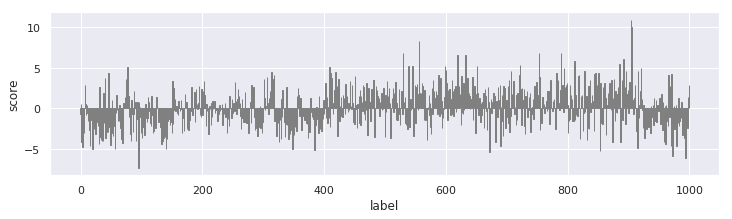

In [11]:
prediction_array = prediction_tensor.detach().numpy()
n_classes = prediction_array.size
plt.figure(figsize=(12, 3))
plt.bar(range(n_classes), prediction_array, edgecolor='gray')
plt.xlabel('label'); plt.ylabel('score'); plt.show()

We can normalize these scores and turn them into proper certainies through softmax. pytorch has an implementation of softmax ready for us.

In [12]:
softmax = torch.nn.Softmax(0)

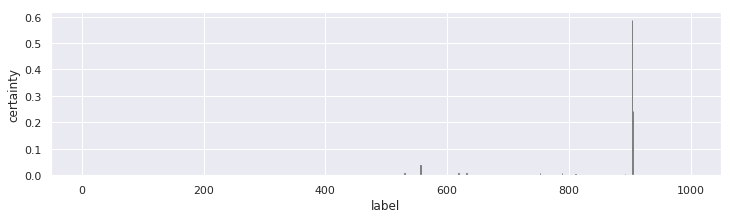

In [13]:
certainty_array = softmax(prediction_tensor).detach().numpy()
plt.figure(figsize=(12, 3))
plt.bar(range(n_classes), certainty_array, edgecolor='gray')
plt.xlabel('label'); plt.ylabel('certainty'); plt.show()

Let's take a look at highest scoring classes, not just the highest scoring one. See [`numpy.argsort`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html).

In [14]:
# TODO Find a permutation that sorts the array.
perm = np.argsort(-prediction_array)

n_top_labels = 10
for i_label in range(n_top_labels):
    label = perm[i_label]
    certainty = certainty_array[label]
    print('{}: {}'.format(label_names[label], certainty_array[label]))

window screen: 0.5870231986045837
window shade: 0.2416054606437683
fire screen, fireguard: 0.03999382257461548
radiator: 0.010120999068021774
shoji: 0.010024410672485828
digital clock: 0.009691459126770496
lampshade, lamp shade: 0.007953333668410778
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system: 0.007464297581464052
wall clock: 0.00442465441301465
space heater: 0.003603065386414528


## Attacking by blurring
Let's see if we can confuse the network by modifying the input image. We apply Gaussian blurs of different strengths and compare the respective predictions. See [`skimage.filters.gaussian`](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian).

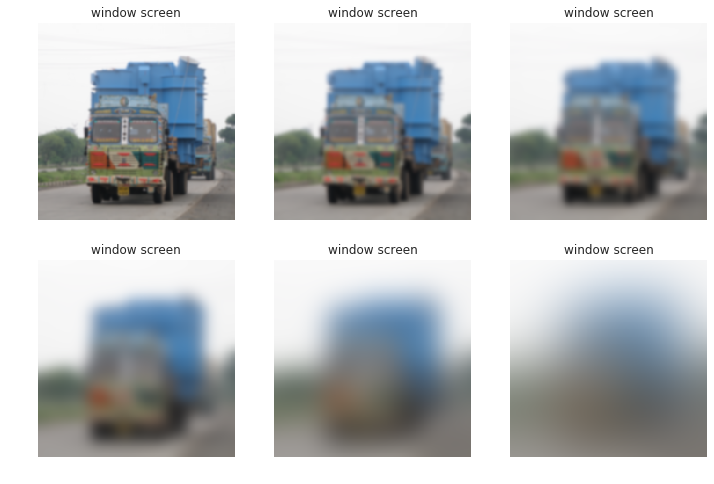

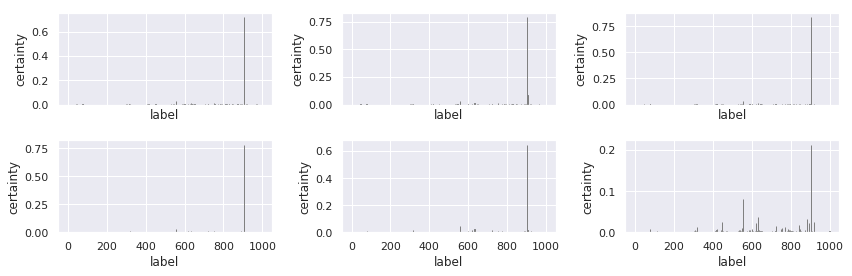

In [15]:
n_rows, n_cols = 2, 3
image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
plot_figure, plot_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 2), sharex=True)
for i_row in range(n_rows):
    for i_col in range(n_cols):
        # Computer blur strength.
        sigma = math.pow(2, i_row * n_cols + i_col)

        # TODO Blur image.
        blurred_image = skimage.filters.gaussian(image, sigma, multichannel=True)

        # Prepare input.
        input_tensor = image_to_tensor(blurred_image)

        # Feed input through network.
        prediction_tensor = model(input_tensor)[0]

        # Determine “winning“ class.
        predicted_label = prediction_tensor.argmax().item()

        # Show image.
        ax = image_axes[i_row, i_col]
        ax.imshow(blurred_image)
        ax.grid(False); ax.axis('off'); ax.set_title(label_names[predicted_label].split(',')[0])

        # Compute certanties.
        certainty_array = softmax(prediction_tensor).detach().numpy()
        ax = plot_axes[i_row, i_col]
        ax.bar(range(n_classes), certainty_array, edgecolor='gray')
        ax.set_xlabel('label'); ax.set_ylabel('certainty')

plt.tight_layout()

Note the differently scaled axes. Although the network does struggle to classify the blurred images “correctly”, this is not exactly a great adversarial attack, because for us humans, too, the blurry images become impossible to understand.

## Gradient-based adversarial attacks
We will now perform a simple attack that takes advantage of two key facts:

- We have complete access to the classifying network.
- The network is differentiable.

The idea is simple. As if we were training the network, we pass an input through it, calculate the error and propagate it backwards through the network. However, we have no interest in changing the network's weights. Instead, we go one step further and calculate the gradients on the input. With these, we can perform gradient **ascent** in order to find an input that produces a *worse* score.

In [16]:
# Prepare input image.
input_tensor = image_to_tensor(image).requires_grad_()

# Prepare target.
original_label = model(input_tensor)[0].argmax().item()
print(original_label)
target_tensor = torch.tensor([original_label], dtype=torch.long)

# Prepare loss.
loss = torch.nn.CrossEntropyLoss()

904


Now for the actual attack… We calculate gradients as though we were training the network. When updating the input, we need to decide on the magnitude of the modification. For this, we simple try increasingly large update values until we change the predicted label. The gradients of a tensor can be accessed via `.grad.data`.

In [17]:
# Pass input through network.
prediction_tensor = model(input_tensor)
print(prediction_tensor.shape)
print(target_tensor.shape)

# Calculate loss.
loss_value = loss(prediction_tensor, target_tensor)
print(loss_value)

# Zero gradients.
model.zero_grad()
input_tensor.grad = None

# Propagate error backwards throught the network.
print('input grad before:', input_tensor.grad)
loss_value.backward()
# print('input grad after:', input_tensor.grad)

# Modify input.
attack_scale = 0.5 * 0.5
new_label = original_label
i = 0
while new_label == original_label and i < 512:
    i += 1
    
    # TODO Increase the magnitude of the attack.
    attack_scale = i * attack_scale

    # TODO Modify the input.
    input_tensor.data = input_tensor.data - attack_scale*input_tensor.grad.data
    # input_tensor.data = input_tensor.data

    # Clamp modified input such that it corresponds to an image.
    input_tensor.data[:, 0, :, :].clamp_(-0.485 / 0.229, (1 - 0.485) / 0.229)
    input_tensor.data[:, 1, :, :].clamp_(-0.456 / 0.224, (1 - 0.456) / 0.224)
    input_tensor.data[:, 2, :, :].clamp_(-0.406 / 0.225, (1 - 0.406) / 0.225)

    # Pass modified input through network.
    prediction_tensor = model(input_tensor)[0]

    # TODO Determine “winning” label.
    new_label = prediction_tensor.argmax().item()

# Print scale.
print('iteration: {}, successful scale: {}'.format(i, attack_scale))

# Calculate certainties.
certainty_tensor = softmax(prediction_tensor)

# Decode label.
print('new label     : {} ({})\tcertainty: {}'.format(new_label, label_names[new_label].split(',')[0], certainty_tensor[new_label]))
print('original label: {} ({})\tcertainty: {}'.format(original_label, label_names[original_label].split(',')[0], certainty_tensor[original_label]))

torch.Size([1, 1000])
torch.Size([1])
tensor(0.5327, grad_fn=<NllLossBackward>)
input grad before: None
iteration: 7, successful scale: 1260.0
new label     : 611 (jigsaw puzzle)	certainty: 0.640049397945404
original label: 904 (window screen)	certainty: 2.3079535822034813e-05


We want to take a look at our result, so we need to convert the modified input tensor back into a numpy array of the correct shape. While we are at it, we visualize the modification.

In [17]:
def tensor_to_image(tensor):
    # Turn from (batch, channel, width, height) tensor into (width, height, channel) array.
    array = tensor[0].detach().numpy().transpose([1, 2, 0])
    
    # Denormalize.
    array = array * [0.229, 0.224, 0.225]
    array = array + [0.485, 0.456, 0.406]
    
    # Clip.
    np.clip(array, 0.0, 1.0, out=array)
    
    return array

modified_image = tensor_to_image(input_tensor)

In [18]:
# Calculate perturbation, that is the difference between the modified image and the original image.
perturbation = modified_image - image
perturbation -= perturbation.min()
perturbation /= perturbation.max()

# The resulting image goes in your submission.
See [`matplotlib.pyplot.savefig`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.savefig.html).

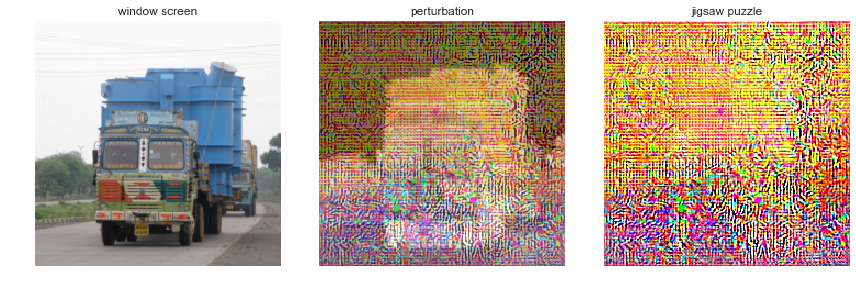

In [19]:
# Prepare figure.
n_rows, n_cols = 1, 3
image_figure, image_axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))

# Show original image.
ax = image_axes[0]
ax.imshow(image)
ax.grid(False); ax.axis('off'); ax.set_title(label_names[original_label].split(',')[0])

# Show original image.
ax = image_axes[1]
ax.imshow(perturbation)
ax.grid(False); ax.axis('off'); ax.set_title('perturbation')

# Show original image.
ax = image_axes[2]
ax.imshow(modified_image)
ax.grid(False); ax.axis('off'); ax.set_title(label_names[new_label].split(',')[0])

plt.tight_layout()

# In your submission, answer the following question.
How does the network typically respond when handed an image as input that contains several different objects? How can we recognize this?

# Extra: Compute a *targeted* attack.